In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
#from sysidentpy.residues.residues_correlation import (
#    compute_residues_autocorrelation,
#    compute_cross_correlation,)
import scipy.stats as stats    
    
SRCdata = "pump_station_data"

df = pd.read_pickle(f'{SRCdata}_filtered.pkl')

In [34]:
basis_function = Polynomial(degree=1) 
model = FROLS( 
    order_selection=True,
    #n_terms= 10,
    n_info_values=10, 
    extended_least_squares=False,
    ylag=5, 
    xlag=5,
    info_criteria="aic", 
    estimator="least_squares", 
    basis_function=basis_function, )


# Select One Day of data to build the model

test_data  = df[["pump4_rpm","outflow"]].loc['2023-02-27':'2023-03-02']
train_data  = df[["pump4_rpm","outflow"]].loc['2023-02-25':'2023-02-26']

c:\Users\manis\anaconda3\Lib\site-packages\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


In [35]:
ytest = test_data["outflow"].values.reshape(-1,1)
ytrain = train_data["outflow"].values.reshape(-1,1)

xtest = test_data["pump4_rpm"].values.reshape(-1,1)
xtrain = train_data["pump4_rpm"].values.reshape(-1,1)

# Training the ARX model
model.fit(X=xtrain, y=ytrain)

# Prediciting on input sequence xtest
yhat = model.predict(X=xtest, y=ytest)

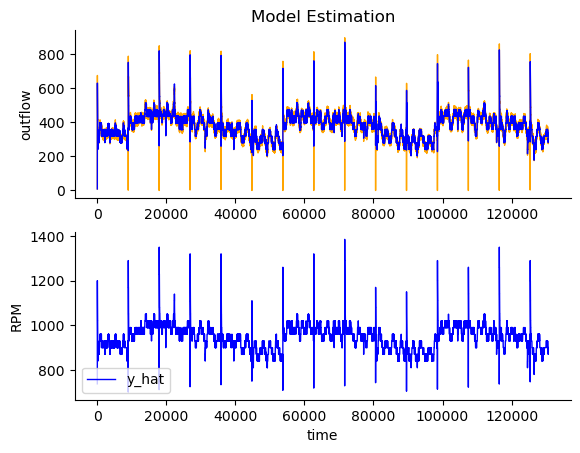

In [36]:
plt.figure()
# steps = 10000
ax1 = plt.subplot(2,1,1)
plt.plot(ytest,color='orange',linewidth=1,label='y')
plt.plot(yhat,color='blue',linewidth=1,label='y_hat')
plt.ylabel('outflow')
# plt.ylim((42,45))
#plt.xlim((0,1000))
plt.title('Model Estimation')
# Shared x-axis
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(xtest,color='blue',linewidth=1,label='xtest')
plt.xlabel('time')
plt.ylabel('RPM')
plt.legend()
plt.show()

In [37]:
mae  = mean_absolute_error(ytest, yhat)
mse  = mean_squared_error(ytest, yhat)
rmse = np.sqrt(mse)
rrse = root_relative_squared_error(ytest, yhat)
print("MAE = " + str(mae))
print("MSE = " + str(mse))
print("RMSE = " + str(rmse))
print("RRSE = " + str(rrse))

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

MAE = 8.257552340238124
MSE = 158.2112663534233
RMSE = 12.578206006955972
RRSE = 0.17942753286230156
  Regressors   Parameters             ERR
0     y(k-1)   1.1854E+00  9.99834994E-01
1     y(k-2)  -2.6809E-01  2.18777758E-05
2    x1(k-2)   1.9303E-01  1.49715649E-06
3          1  -9.2935E+01  2.34052237E-05
4    x1(k-5)  -7.9130E-02  7.74330774E-07
5    x1(k-1)  -5.0629E-02  5.54373636E-07
6    x1(k-3)   6.7353E-02  2.68366156E-07
7     y(k-3)  -4.4923E-02  3.95008382E-08
8     y(k-5)   1.7320E-02  1.07704902E-07
9    x1(k-4)   1.1704E-02  7.54913711E-09


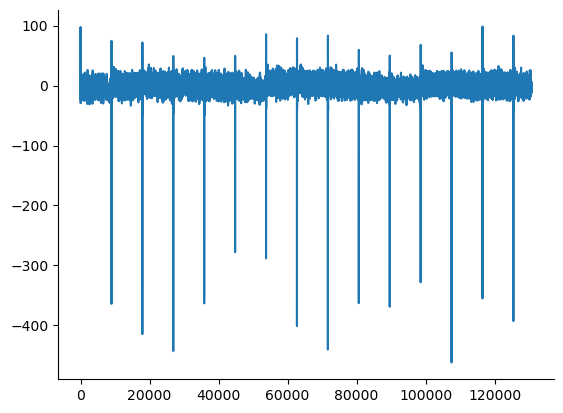

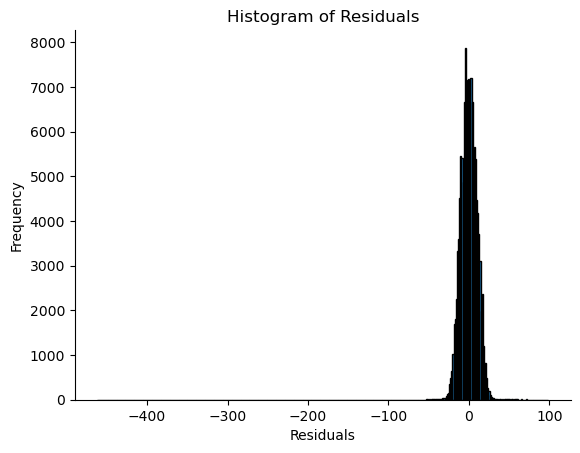

Shapiro-Wilk Test Statistic: 0.7188235521316528, P-value: 0.0
The residuals do not follow a normal distribution (reject H0)


c:\Users\manis\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [38]:
residuals = ytest - yhat

plt.figure()
plt.plot(residuals)
# Plotting the histogram of residuals
plt.figure()
plt.hist(residuals, bins=400, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

shapiro_test = stats.shapiro(residuals)

print(f"Shapiro-Wilk Test Statistic: {shapiro_test[0]}, P-value: {shapiro_test[1]}")

# Interpretation
alpha = 0.05
if shapiro_test[1] < alpha:
    print("The residuals do not follow a normal distribution (reject H0)")
else:
    print("The residuals follow a normal distribution (fail to reject H0)")

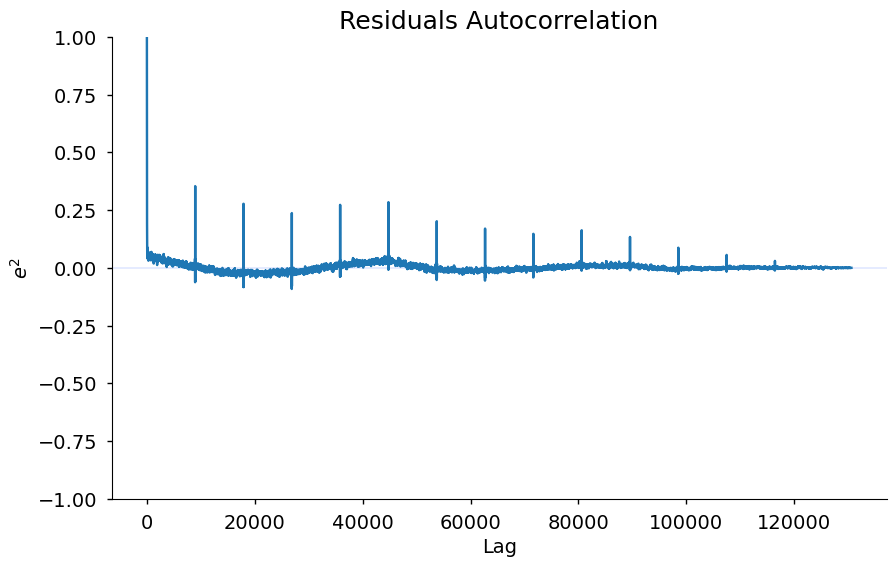

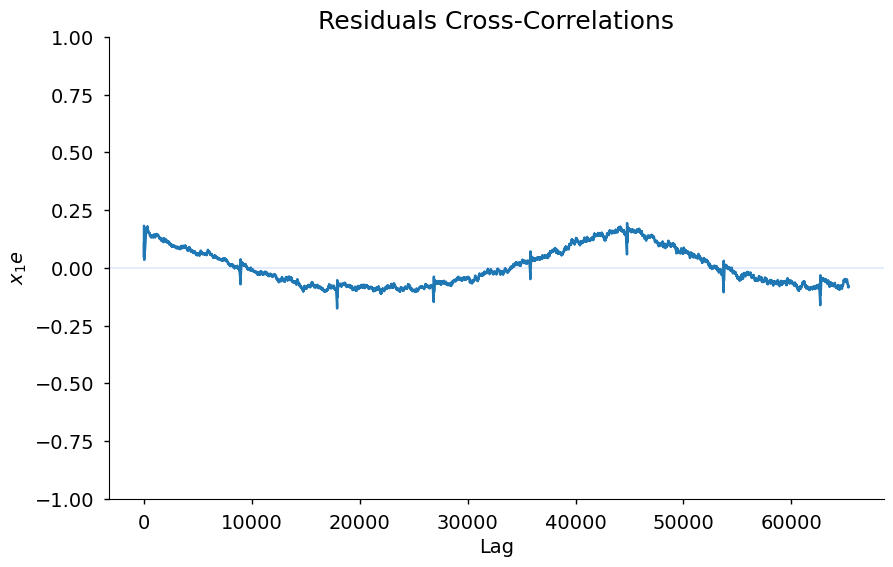

In [39]:
#print(plt.style.available)
# If seaborn-v0_8-notebook style is not available, 
# pick a random style from the ones available in yout matplotlib

ee = compute_residues_autocorrelation(ytest, yhat) #Correlation of the residual with itself
#========================
#Plot the residuals correlation or autocorrelation.
plot_residues_correlation(data=ee, title="Residuals Autocorrelation",
                          ylabel="$e^2$", 
                          style='seaborn-v0_8-notebook')
#========================
#Plot the cross-correlation of the residuals. 
x1e = compute_cross_correlation(ytest, yhat, xtest)
plot_residues_correlation(data=x1e, title="Residuals Cross-Correlations", 
                          ylabel="$x_1e$", 
                          style='seaborn-v0_8-notebook')